In [ ]:
import re
import html
import pandas as pd
import numpy as np
import warnings
import csv
warnings.filterwarnings('ignore')

In [ ]:
!pip install tensorflow-text

In [ ]:
!pip install transformers -U

In [ ]:
!pip install accelerate -U

In [ ]:
!pip install transformers[torch]

In [ ]:
from google.colab import files
import nltk
from nltk.corpus import stopwords
from textblob import Word, TextBlob
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from numpy import array
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import torch
from torch.utils.data import DataLoader, RandomSampler
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from keras import regularizers
import keras
import keras.utils
from keras import utils as np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D,SpatialDropout1D,Bidirectional
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report
from keras.utils import to_categorical
from sklearn import neighbors
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from transformers import BertTokenizer, BertForSequenceClassification,BertForMaskedLM,AutoModel, AutoTokenizer
import pickle

In [ ]:
df_train = pd.read_csv(r"/content/drive/MyDrive/disaster_train.csv",on_bad_lines='skip')

In [ ]:
df_test = pd.read_csv(r"/content/drive/MyDrive/disaster_test.csv",on_bad_lines='skip')

In [ ]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Word Cloud of all tweets:

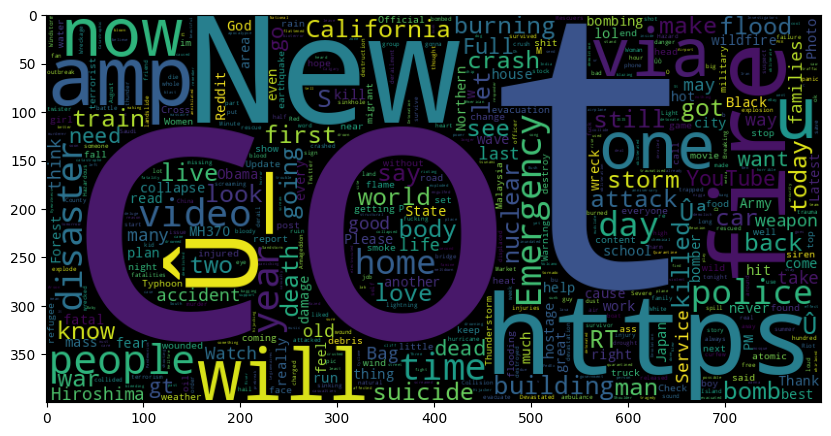

In [ ]:
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 1000 , width = 800 , height = 400,
               collocations=False).generate(" ".join(df_train["text"]))
plt.imshow(wc)

In [ ]:
df_train.shape

(7613, 5)

In [ ]:
df_train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
df_train.drop_duplicates(inplace=True)
# df_train.dropna(inplace=True)

In [ ]:
df_train.reset_index(inplace = True,drop=True)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('english')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Function for cleaning/preprocessing tweets.

In [ ]:
def clean_text(text):
  text = re.sub(r'<[^>]*>', '', text)          # Removing HTML tags
  text = html.unescape(text)                   # Removing HTML escape characters
  text = text.lower().replace('\n',' ').replace('\r','').strip()
  text = re.sub(r'[^\w\s]', '', text)          # Removing non-alphanumeric characters
  text = re.sub(r'\s+', ' ', text).strip()     # Removing spaces
  stop_words = set(stopwords.words('english'))

  lemmatizer = WordNetLemmatizer()
  text = lemmatizer.lemmatize(text)
  word_tokens = word_tokenize(text)

  filtered_sentence = [lemmatizer.lemmatize(w) for w in word_tokens if w not in stop_words]
  text = " ".join(filtered_sentence)

  return text

In [ ]:
df_train['cleaned_tweets'] = df_train['text'].apply(lambda text: clean_text(text))

In [ ]:
df_train.head()

,id,keyword,location,text,target,cleaned_tweets
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident asked shelter place notified officer ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfire pour...


Function to obtain Tf-IDF embeddings of the tweets.

In [ ]:
def tf_idf(df,col,max_features):
  corpus = df[''+col+'']
  vectorizer = TfidfVectorizer(max_features = max_features)
  X = vectorizer.fit_transform(corpus).toarray()
  return X

In [ ]:
def train_test(y,train_set,test_size):
  X_train, X_test, y_train, y_test = train_test_split(train_set, y, test_size = test_size, random_state = 0)
  return X_train, X_test, y_train, y_test

Tfidf:

In [ ]:
X = tf_idf(df_train,'cleaned_tweets',20000)

In [ ]:
y = np.array(df_train.drop(['id','keyword','location','text','cleaned_tweets'],axis=1))

In [ ]:
X_train, X_test, y_train, y_test = train_test(y,X,0.2)

In [ ]:
def predict_lr():
  classifier = LogisticRegression(random_state=0).fit(X_train, y_train)
  return classifier

In [ ]:
def decision_tree():
  model = DecisionTreeClassifier()
  model.fit(X_train, y_train)
  return model

Function to get predictions for a given model and create a classification report for the same(classification report here includes the Precision, Recall, F1-score and accuracy for each label along with averages).

In [ ]:
def evaluate_performance_short(df,pred_func):
  model = pred_func()
  results_df = pd.DataFrame()
  results_df['target'] = df[len(df)-len(y_test):len(df)]['target']
  results_df['Predicted_intent'] = model.predict(X_test)
  print(classification_report(results_df['Predicted_intent'],results_df['target']))

In [ ]:
evaluate_performance_short(df_train,predict_lr)

              precision    recall  f1-score   support

           0       0.71      0.54      0.61      1060
           1       0.32      0.49      0.38       463

    accuracy                           0.53      1523
   macro avg       0.51      0.51      0.50      1523
weighted avg       0.59      0.53      0.54      1523



In [ ]:
evaluate_performance_short(df_train,decision_tree)

              precision    recall  f1-score   support

           0       0.61      0.53      0.57       933
           1       0.38      0.46      0.42       590

    accuracy                           0.50      1523
   macro avg       0.50      0.50      0.49      1523
weighted avg       0.52      0.50      0.51      1523



Function to create a CNN model for disaster tweet classification where we can pass the required optimizer as a parameter.

In [ ]:
def cnn(optimizer):
  X = df_train['cleaned_tweets'].values
  Y = df_train['target'].values
  max_len = len(df_train['cleaned_tweets'].max())
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42) # Check random_state

  tokenizer = Tokenizer(num_words=1000)
  tokenizer.fit_on_texts(X_train)                 # Creates a vocabulary based on X_train
  X_train = tokenizer.texts_to_sequences(X_train)
  X_test = tokenizer.texts_to_sequences(X_test)
  X_train = pad_sequences(X_train, maxlen=max_len)
  X_test = pad_sequences(X_test, maxlen=max_len)

  model = Sequential()
  model.add(Embedding(1000, 50, input_length=max_len))  # 1000 tells us the vocabulary size
  # 50 the number of dimensions in which to represent each word.
  model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
  model.add(GlobalMaxPooling1D())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))                     # Substitiutes random parts of the data with 0s to prevent overfitting
  model.add(Dense(2, activation='softmax'))   # O/p layer, with 2 o/p neurons for 2 categories.

  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  model.fit(X_train,tf.keras.utils.to_categorical(y_train), validation_split=0.1, epochs=5, batch_size=32)

  y_pred = model.predict(X_test)
  classes_x = np.argmax(y_pred,axis=1)
  print(classification_report(y_test, classes_x))
  return model

1. Adam optimizer: It is a popular optimization algorithm for training machine learning models, including those used for text classification.It combines the advantages of two other optimization algorithms, Adagrad and RMSprop.

In [ ]:
model1 = cnn('adam')

Epoch 1/5
172/172 [==============================] - 9s 43ms/step - loss: 0.5714 - accuracy: 0.7046 - val_loss: 0.4522 - val_accuracy: 0.7882
Epoch 2/5
172/172 [==============================] - 2s 12ms/step - loss: 0.3932 - accuracy: 0.8312 - val_loss: 0.4441 - val_accuracy: 0.7964
Epoch 3/5
172/172 [==============================] - 2s 14ms/step - loss: 0.3176 - accuracy: 0.8717 - val_loss: 0.4569 - val_accuracy: 0.8046
Epoch 4/5
172/172 [==============================] - 2s 11ms/step - loss: 0.2521 - accuracy: 0.9037 - val_loss: 0.4869 - val_accuracy: 0.8013
Epoch 5/5
48/48 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.78      0.81      0.79       874
           1       0.72      0.69      0.71       649

    accuracy                           0.76      1523
   macro avg       0.75      0.75      0.75      1523
weighted avg       0.76      0.76      0.76      1523



2. Stochastic Gradient Descent: Unlike the Adam optimizer, which is an adaptive optimizer, SGD is a more traditional and straightforward optimization algorithm. It is another optimization algorithm commonly used for text classification.

In [ ]:
model2 = cnn('SGD')

Epoch 1/5
172/172 [==============================] - 20s 104ms/step - loss: 0.5756 - accuracy: 0.6939 - val_loss: 0.4504 - val_accuracy: 0.8079
Epoch 2/5
172/172 [==============================] - 2s 14ms/step - loss: 0.3913 - accuracy: 0.8307 - val_loss: 0.4286 - val_accuracy: 0.7980
Epoch 3/5
172/172 [==============================] - 2s 11ms/step - loss: 0.3239 - accuracy: 0.8659 - val_loss: 0.4526 - val_accuracy: 0.8128
Epoch 4/5
172/172 [==============================] - 1s 7ms/step - loss: 0.2649 - accuracy: 0.8984 - val_loss: 0.4948 - val_accuracy: 0.7915
Epoch 5/5
48/48 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.79      0.82      0.80       874
           1       0.75      0.70      0.72       649

    accuracy                           0.77      1523
   macro avg       0.77      0.76      0.76      1523
weighted avg       0.77      0.77      0.77      1523



3. AdaGrad: It adapts the learning rates for each parameter during training, which can be beneficial when dealing with sparse data or when different features have varying importance.

In [ ]:
model3 = cnn('AdaGrad')

Epoch 1/5
172/172 [==============================] - 11s 56ms/step - loss: 0.5700 - accuracy: 0.6964 - val_loss: 0.4509 - val_accuracy: 0.7833
Epoch 2/5
172/172 [==============================] - 2s 12ms/step - loss: 0.3886 - accuracy: 0.8243 - val_loss: 0.4403 - val_accuracy: 0.7997
Epoch 3/5
172/172 [==============================] - 1s 8ms/step - loss: 0.3137 - accuracy: 0.8714 - val_loss: 0.4546 - val_accuracy: 0.8046
Epoch 4/5
172/172 [==============================] - 1s 7ms/step - loss: 0.2505 - accuracy: 0.9077 - val_loss: 0.5159 - val_accuracy: 0.7882
Epoch 5/5
48/48 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.79      0.80      0.79       874
           1       0.72      0.71      0.72       649

    accuracy                           0.76      1523
   macro avg       0.76      0.75      0.76      1523
weighted avg       0.76      0.76      0.76      1523



4. RMSprop:  It is an adaptive learning rate method that adjusts the learning rates for each parameter during training, making it well-suited for tasks where the gradients of different features or parameters have varying magnitudes.

In [ ]:
model4 = cnn('RMSprop')

Epoch 1/5
172/172 [==============================] - 11s 54ms/step - loss: 0.6011 - accuracy: 0.6802 - val_loss: 0.4623 - val_accuracy: 0.7865
Epoch 2/5
172/172 [==============================] - 3s 15ms/step - loss: 0.4213 - accuracy: 0.8088 - val_loss: 0.4326 - val_accuracy: 0.7997
Epoch 3/5
172/172 [==============================] - 1s 7ms/step - loss: 0.3702 - accuracy: 0.8398 - val_loss: 0.4442 - val_accuracy: 0.7980
Epoch 4/5
172/172 [==============================] - 1s 7ms/step - loss: 0.3299 - accuracy: 0.8633 - val_loss: 0.4450 - val_accuracy: 0.7915
Epoch 5/5
48/48 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.83      0.71      0.76       874
           1       0.67      0.80      0.73       649

    accuracy                           0.75      1523
   macro avg       0.75      0.75      0.75      1523
weighted avg       0.76      0.75      0.75      1523



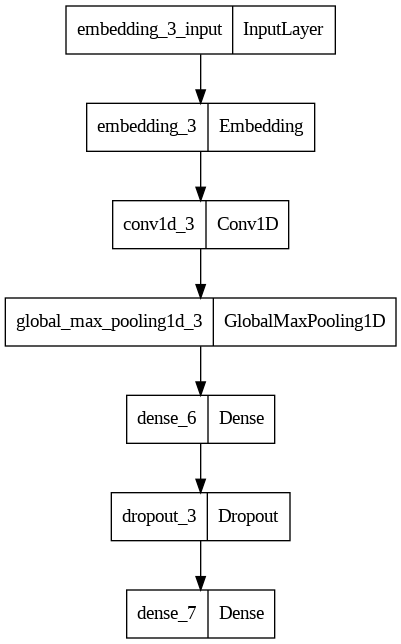

In [ ]:
tf.keras.utils.plot_model(
    model4,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False,
)

Hyperparameter tuning for CNN:

In [ ]:
X = df_train['cleaned_tweets'].values
Y = df_train['target'].values
max_len = len(df_train['cleaned_tweets'].max())
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42) # Check random_state

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)                 # Creates a vocabulary based on X_train
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
!pip install keras-tuner

build_model function is defined to create CNN models for hyperparameter tuning in order to obtain the best parameters for the model. Here hp is the base class used for hyperparameter optimization.

In [ ]:
def build_model(hp):
  max_len = len(df_train['cleaned_tweets'].max())
  model = keras.Sequential([
    keras.layers.Embedding(10000, 5000, input_length=max_len),
    keras.layers.Conv1D(
        filters=hp.Int('conv_1_filter', min_value=128, max_value=256, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        padding='same',
        activation='relu'
    ),
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=128, max_value=256, step=16),
        activation='relu'
    ),
    keras.layers.Dropout(hp.Float('dropout', 0, 0.9, step=0.3, default=0.5)),
    keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer=keras.optimizers.RMSprop(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='BinaryCrossentropy',
              metrics=['accuracy'])

  return model

In [ ]:
from kerastuner import RandomSearch
import keras_tuner

Using TensorFlow backend


Random search is a hyperparameter tuning technique which, instead of exhaustively trying all possible combinations of hyperparameters, random search samples from a predefined range or distribution of hyperparameters.

In [ ]:
tuner = RandomSearch(build_model,
                     objective='val_accuracy',
                     max_trials=5,directory='output',project_name="Disaster_tweets")

Reloading Tuner from output/Disaster_tweets/tuner0.json


In [ ]:
tuner.search(X_train,y_train,epochs=5,validation_split=0.1)

Best parameters obtained:

In [ ]:
tuner.results_summary()

Results summary
Results in output/Disaster_tweets
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
conv_1_filter: 240
conv_1_kernel: 3
dense_1_units: 224
dropout: 0.8999999999999999
learning_rate: 0.001
Score: 0.8160919547080994

Trial 4 summary
Hyperparameters:
conv_1_filter: 160
conv_1_kernel: 5
dense_1_units: 256
dropout: 0.8999999999999999
learning_rate: 0.001
Score: 0.8128078579902649

Trial 3 summary
Hyperparameters:
conv_1_filter: 240
conv_1_kernel: 5
dense_1_units: 160
dropout: 0.0
learning_rate: 0.001
Score: 0.8111658692359924

Trial 2 summary
Hyperparameters:
conv_1_filter: 224
conv_1_kernel: 3
dense_1_units: 256
dropout: 0.6
learning_rate: 0.01
Score: 0.8062397241592407

Trial 1 summary
Hyperparameters:
conv_1_filter: 256
conv_1_kernel: 5
dense_1_units: 208
dropout: 0.3
learning_rate: 0.001
Score: 0.802955687046051


Storing the model with the best hyperparams:

In [ ]:
cnn_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 45, 5000)          50000000  
                                                                 
 conv1d (Conv1D)             (None, 45, 208)           3120208   
                                                                 
 global_max_pooling1d (Glob  (None, 208)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 128)               26752     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                        

In [ ]:
# cnn_model.fit(X_train,y_train, epochs=25, validation_split=0.1, initial_epoch=5)

In [ ]:
y_probs = cnn_model.predict(X_test)

48/48 [==============================] - 1s 9ms/step


Function to get predicted class labels from predicted probabilities.

In [ ]:
def get_preds(y_probs,threshold):
  y_pred_test = np.empty_like(y_probs)
  y_pred_test[:] = (y_probs[:] > threshold) * 1
  return y_pred_test

In [ ]:
y_pred = get_preds(y_probs,0.5)

In [ ]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

         0.0       0.87      0.79      0.83       961
         1.0       0.69      0.79      0.74       562

    accuracy                           0.79      1523
   macro avg       0.78      0.79      0.78      1523
weighted avg       0.80      0.79      0.79      1523



In [ ]:
y_pred_preds = cnn_model.predict(X_test)
cnn_fpr, cnn_tpr, _ = metrics.roc_curve(y_test, y_pred_preds)

48/48 [==============================] - 14s 15ms/step


In [ ]:
y_pred_preds = model1.predict(X_test)
cnn_fpr1, cnn_tpr1, _ = metrics.roc_curve(y_test, y_pred_preds.argmax(axis=1))

48/48 [==============================] - 0s 2ms/step


In [ ]:
y_pred_preds = model2.predict(X_test)
cnn_fpr2, cnn_tpr2, _ = metrics.roc_curve(y_test, y_pred_preds.argmax(axis=1))

48/48 [==============================] - 0s 2ms/step


In [ ]:
y_pred_preds = model3.predict(X_test)
cnn_fpr3, cnn_tpr3, _ = metrics.roc_curve(y_test, y_pred_preds.argmax(axis=1))

48/48 [==============================] - 0s 3ms/step


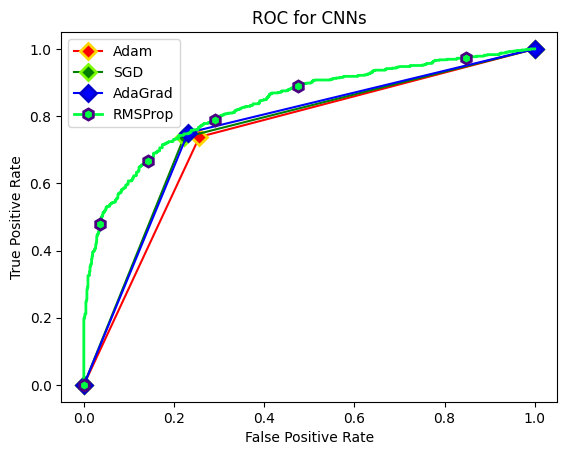

In [ ]:
plt.plot(cnn_fpr1, cnn_tpr1, color = 'r', label='Adam',marker="D",
         markersize=8, markeredgecolor="gold",
         markeredgewidth=2)
plt.plot(cnn_fpr2, cnn_tpr2,  color = 'g', label='SGD',marker="D",
         markersize=8, markeredgecolor="lawngreen",
         markeredgewidth=2)
plt.plot(cnn_fpr3, cnn_tpr3,  color = 'b', label='AdaGrad',marker="D",
         markersize=8, markeredgecolor="mediumblue",
         markeredgewidth=2)
plt.plot(cnn_fpr, cnn_tpr,color = '#00ff40', label='RMSProp',linewidth=2,marker="h",
         markersize=8, markeredgecolor="indigo",
         markeredgewidth=2,markevery=100)
plt.title("ROC for CNNs")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

BERT embeddings:

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Function to obtain BERT embeddings for tweets from a pretrained BERT LLM.

In [ ]:
def get_bert_embeds(df,col):
  X1 = df[''+col+''].tolist()
  word_tokens = tokenizer(X1, padding=True, truncation=True)
  ids = torch.tensor(word_tokens['input_ids'])
  word_embeddings = model.bert.embeddings.word_embeddings(ids)
  return word_embeddings

In [ ]:
X_bert = get_bert_embeds(df_train,'cleaned_tweets')

In [ ]:
X_bert.shape

torch.Size([7613, 52, 768])

In [ ]:
y = np.array(df_train.drop(['id','keyword','location','text','cleaned_tweets'],axis=1))

In [ ]:
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test(y,X_bert,0.2)

Function to create a BERT-CNN model for disaster tweet classification.

In [ ]:
def bert_cnn(optimizer,X_train,X_test,y_train,y_test):
  max_len = len(df_train['cleaned_tweets'].max())
  model = Sequential()
  model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
  model.add(GlobalMaxPooling1D())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))                     # Substitiutes random parts of the data with 0s to prevent overfitting
  model.add(Dense(2, activation='softmax'))   # O/p layer, with 2 o/p neurons for 2 categories.

  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  model.fit(X_train,tf.keras.utils.to_categorical(y_train), validation_split=0.1, epochs=10, batch_size=32)

  y_pred = model.predict(X_test)
  classes_x = np.argmax(y_pred,axis=1)
  print(classification_report(y_test, classes_x))
  return model

In [ ]:
bert_cnn1 = bert_cnn('RMSprop',X_train_bert.detach().numpy(), X_test_bert.detach().numpy(), y_train_bert, y_test_bert)

Epoch 1/10
172/172 [==============================] - 6s 11ms/step - loss: 0.6437 - accuracy: 0.6360 - val_loss: 0.5827 - val_accuracy: 0.7537
Epoch 2/10
172/172 [==============================] - 1s 7ms/step - loss: 0.5152 - accuracy: 0.7577 - val_loss: 0.4832 - val_accuracy: 0.7980
Epoch 3/10
172/172 [==============================] - 1s 7ms/step - loss: 0.4186 - accuracy: 0.8161 - val_loss: 0.6795 - val_accuracy: 0.7192
Epoch 4/10
172/172 [==============================] - 1s 7ms/step - loss: 0.3680 - accuracy: 0.8446 - val_loss: 0.5274 - val_accuracy: 0.7882
Epoch 5/10
172/172 [==============================] - 1s 7ms/step - loss: 0.3178 - accuracy: 0.8708 - val_loss: 0.4933 - val_accuracy: 0.7668
Epoch 6/10
172/172 [==============================] - 1s 7ms/step - loss: 0.2722 - accuracy: 0.8896 - val_loss: 0.6325 - val_accuracy: 0.7159
Epoch 7/10
172/172 [==============================] - 2s 9ms/step - loss: 0.2433 - accuracy: 0.8997 - val_loss: 0.5559 - val_accuracy: 0.7849
Epoch

BERT-CNN without an optimizer:

In [ ]:
def simple_bert_cnn(X_train,X_test,y_train,y_test):
  max_len = len(df_train['cleaned_tweets'].max())
  model = Sequential()
  model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
  model.add(GlobalMaxPooling1D())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))                     # Substitiutes random parts of the data with 0s to prevent overfitting
  model.add(Dense(2, activation='softmax'))   # O/p layer, with 2 o/p neurons for 2 categories.

  model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
  model.fit(X_train,tf.keras.utils.to_categorical(y_train), validation_split=0.1, epochs=10, batch_size=32)

  y_pred = model.predict(X_test)
  classes_x = np.argmax(y_pred,axis=1)
  print(classification_report(y_test, classes_x))
  return model

In [ ]:
s_bert_cnn1 = simple_bert_cnn(X_train_bert.detach().numpy(), X_test_bert.detach().numpy(), y_train_bert, y_test_bert)

Epoch 1/10
172/172 [==============================] - 2s 9ms/step - loss: 0.6466 - accuracy: 0.6245 - val_loss: 0.7272 - val_accuracy: 0.5747
Epoch 2/10
172/172 [==============================] - 1s 7ms/step - loss: 0.5068 - accuracy: 0.7581 - val_loss: 0.5021 - val_accuracy: 0.7570
Epoch 3/10
172/172 [==============================] - 1s 7ms/step - loss: 0.4225 - accuracy: 0.8084 - val_loss: 0.7265 - val_accuracy: 0.6305
Epoch 4/10
172/172 [==============================] - 1s 7ms/step - loss: 0.3627 - accuracy: 0.8466 - val_loss: 0.4932 - val_accuracy: 0.7701
Epoch 5/10
172/172 [==============================] - 2s 10ms/step - loss: 0.3156 - accuracy: 0.8710 - val_loss: 0.5799 - val_accuracy: 0.7800
Epoch 6/10
172/172 [==============================] - 2s 10ms/step - loss: 0.2761 - accuracy: 0.8854 - val_loss: 0.5285 - val_accuracy: 0.7521
Epoch 7/10
172/172 [==============================] - 2s 9ms/step - loss: 0.2257 - accuracy: 0.9122 - val_loss: 0.5947 - val_accuracy: 0.7406
Epoc

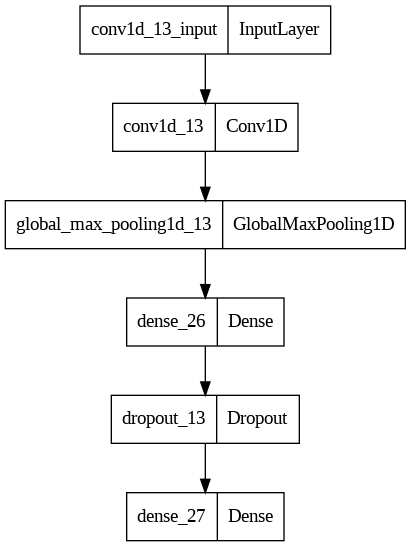

In [ ]:
tf.keras.utils.plot_model(
    bert_cnn1,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False,
)

Hyperparameter tuning for BERT-CNN:

In [ ]:
X_bert = get_bert_embeds(df_train,'cleaned_tweets')

In [ ]:
y = np.array(df_train.drop(['id','keyword','location','text','cleaned_tweets'],axis=1))

In [ ]:
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test(y,X_bert,0.2)

build_model2 function is defined to create BERT-CNN models for hyperparameter tuning in order to obtain the best parameters for the model. Here hp is the base class used for hyperparameter optimization.

In [ ]:
def build_model2(hp):
  max_len = len(df_train['cleaned_tweets'].max())
  model = keras.Sequential([
    keras.layers.Conv1D(
        filters=hp.Int('conv_1_filter', min_value=128, max_value=256, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        padding='same',
        activation='relu',
        input_shape = X_train_bert.detach().numpy().shape[1:]
    ),
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=128, max_value=256, step=16),
        activation='relu'
    ),
    keras.layers.Dropout(hp.Float('dropout', 0, 0.9, step=0.3, default=0.5)),
    keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer=keras.optimizers.RMSprop(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='BinaryCrossentropy',
              metrics=['accuracy'])

  return model

In [ ]:
tuner = RandomSearch(build_model2,
                     objective='val_accuracy',
                     max_trials=5,directory='output',project_name="Disaster_tweets2")

In [ ]:
tuner.search(X_train_bert.detach().numpy(),y_train_bert,epochs=5,validation_split=0.1)

Trial 5 Complete [00h 00m 14s]
val_accuracy: 0.7881773114204407

Best val_accuracy So Far: 0.802955687046051
Total elapsed time: 00h 01m 18s


In [ ]:
tuner.results_summary()

Results summary
Results in output/Disaster_tweets2
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
conv_1_filter: 208
conv_1_kernel: 5
dense_1_units: 224
dropout: 0.3
learning_rate: 0.001
Score: 0.7947455048561096

Trial 4 summary
Hyperparameters:
conv_1_filter: 160
conv_1_kernel: 5
dense_1_units: 128
dropout: 0.3
learning_rate: 0.001
Score: 0.7931034564971924

Trial 2 summary
Hyperparameters:
conv_1_filter: 144
conv_1_kernel: 3
dense_1_units: 176
dropout: 0.6
learning_rate: 0.01
Score: 0.7684729099273682

Trial 1 summary
Hyperparameters:
conv_1_filter: 192
conv_1_kernel: 3
dense_1_units: 240
dropout: 0.6
learning_rate: 0.01
Score: 0.7635468244552612

Trial 3 summary
Hyperparameters:
conv_1_filter: 176
conv_1_kernel: 3
dense_1_units: 256
dropout: 0.8999999999999999
learning_rate: 0.01
Score: 0.7487684488296509


In [ ]:
bert_cnn_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
bert_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 52, 160)           614560    
                                                                 
 global_max_pooling1d (Glob  (None, 160)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 144)               23184     
                                                                 
 dropout (Dropout)           (None, 144)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 145       
                                                                 
Total params: 637889 (2.43 MB)
Trainable params: 637889 (2.43 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [ ]:
y_probs = bert_cnn_model.predict(X_test_bert.detach().numpy())

48/48 [==============================] - 0s 5ms/step


In [ ]:
def get_preds(y_probs,threshold):
  y_pred_test = np.empty_like(y_probs)
  y_pred_test[:] = (y_probs[:] > threshold) * 1
  return y_pred_test

In [ ]:
y_pred = get_preds(y_probs,0.5)

In [ ]:
print(classification_report(y_pred,y_test_bert))

              precision    recall  f1-score   support

         0.0       0.92      0.78      0.84      1039
         1.0       0.64      0.85      0.73       484

    accuracy                           0.80      1523
   macro avg       0.78      0.81      0.79      1523
weighted avg       0.83      0.80      0.81      1523



In [ ]:
dt_model = decision_tree()
y_pred_proba = dt_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)

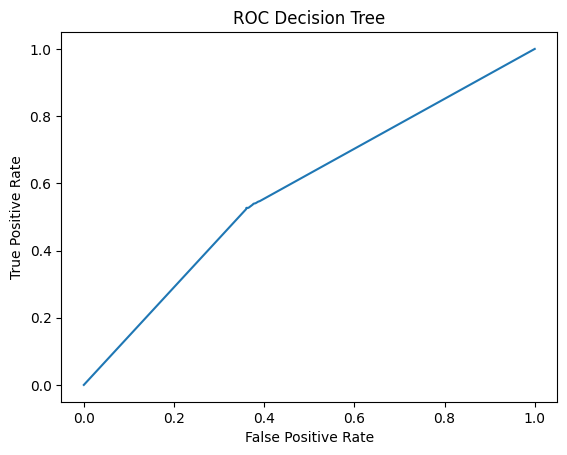

In [ ]:
plt.plot(fpr,tpr)
plt.title("ROC Decision Tree")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# def bert_cnn(X_train,X_test,y_train,y_test):
#   max_len = len(df_train['cleaned_tweets'].max())
#   model = Sequential()
#   model.add(Conv1D(filters=240, kernel_size=5, padding='same', activation='relu',input_shape = X_train.shape[1:]))
#   model.add(GlobalMaxPooling1D())
#   model.add(Dense(192, activation='relu'))
#   model.add(Dropout(0.6))                     # Substitiutes random parts of the data with 0s to prevent overfitting
#   model.add(Dense(2, activation='softmax'))

#   model.compile(loss='BinaryCrossentropy', optimizer=keras.optimizers.RMSprop(learning_rate = 0.001), metrics=['accuracy'])
#   model.fit(X_train,tf.keras.utils.to_categorical(y_train), validation_split=0.1, epochs=10, batch_size=32)

#   y_pred = model.predict(X_test)
#   classes_x = np.argmax(y_pred,axis=1)
#   print(classification_report(y_test, classes_x))
#   return model

In [ ]:
# bert_cnn1 = bert_cnn(X_train_bert.detach().numpy(), X_test_bert.detach().numpy(), y_train_bert, y_test_bert)

In [ ]:
# bert_cnn_model.save("bert_cnn_tweets.pkl")

In [ ]:
pickle.dump(bert_cnn_model, open('bert_cnn_tweets1.pkl','wb'))

In [ ]:
lr_model = predict_lr()
y_pred_proba = lr_model.predict_proba(X_test)[::,1]
lr_fpr, lr_tpr, _ = metrics.roc_curve(y_test, y_pred_proba)

In [ ]:
dt_model = decision_tree()
y_pred_proba = dt_model.predict_proba(X_test)[::,1]
dt_fpr, dt_tpr, _ = metrics.roc_curve(y_test, y_pred_proba)

In [ ]:
y_pred_preds = bert_cnn_model.predict(X_test_bert.detach().numpy())
bert_fpr, bert_tpr, _ = metrics.roc_curve(y_test_bert, y_pred_preds)

48/48 [==============================] - 1s 13ms/step


In [ ]:
y_pred_preds = cnn_model.predict(X_test)
cnn_fpr, cnn_tpr, _ = metrics.roc_curve(y_test, y_pred_preds)

48/48 [==============================] - 0s 7ms/step


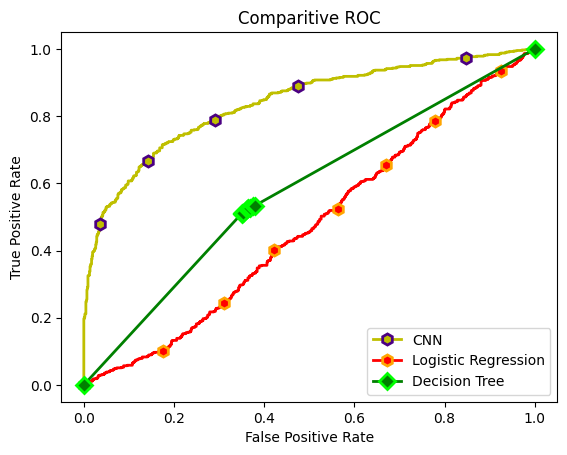

In [ ]:
# plt.plot(bert_fpr, bert_tpr, label='BERT-CNN')
plt.plot(cnn_fpr, cnn_tpr,color = 'y', label='CNN',linewidth=2,marker="h",
         markersize=8, markeredgecolor="indigo",
         markeredgewidth=2,markevery=100)
plt.plot(lr_fpr,lr_tpr, color = 'r', label='Logistic Regression',linewidth=2,marker="h",
         markersize=8, markeredgecolor="orange",
         markeredgewidth=2,markevery=100)
plt.plot(dt_fpr,dt_tpr,  color = 'g', label='Decision Tree',linewidth=2,marker="D",
         markersize=8, markeredgecolor="lime",
         markeredgewidth=2)
plt.title("Comparitive ROC")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [ ]:
y_pred_preds = s_bert_cnn1.predict(X_test_bert.detach().numpy())
s_bert_fpr, s_bert_tpr, _ = metrics.roc_curve(y_test, y_pred_preds.argmax(axis=1))

48/48 [==============================] - 0s 8ms/step


BERT-CNN with RMSprop gives the best curve.

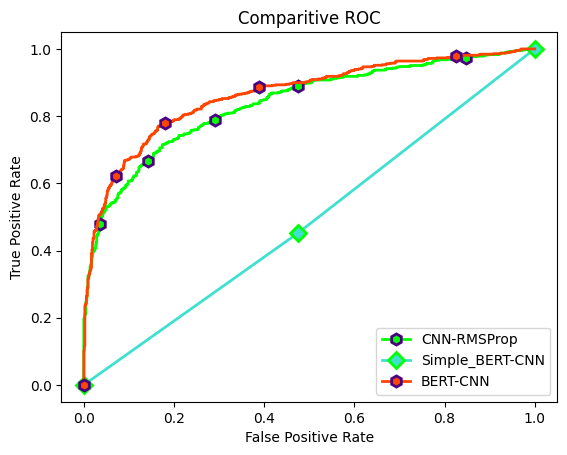

In [ ]:
plt.plot(cnn_fpr, cnn_tpr,color = 'lime', label='CNN-RMSProp',linewidth=2,marker="h",
         markersize=8, markeredgecolor="indigo",
         markeredgewidth=2,markevery=100)
plt.plot(s_bert_fpr, s_bert_tpr,color = 'turquoise', label='Simple_BERT-CNN',linewidth=2,marker="D",
         markersize=8, markeredgecolor="lime",
         markeredgewidth=2)
plt.plot(bert_fpr, bert_tpr,color = 'orangered', label='BERT-CNN',linewidth=2,marker="h",
         markersize=8, markeredgecolor="indigo",
         markeredgewidth=2,markevery=100)
plt.title("Comparitive ROC")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

BERT-LSTM:

In [ ]:
def bert_lstm(optimizer,X_train,X_test,y_train,y_test):
  model = Sequential()
  model.add(Bidirectional(LSTM(64)))
  model.add(Dense(2, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  model.fit(X_train,tf.keras.utils.to_categorical(y_train), validation_split=0.1, epochs=5, batch_size=32)

  y_pred = model.predict(X_test)
  classes_x = np.argmax(y_pred,axis=1)
  print(classification_report(y_test, classes_x))

In [ ]:
bert_lstm('RMSprop',X_train_bert.detach().numpy(), X_test_bert.detach().numpy(), y_train_bert, y_test_bert)

Epoch 1/5
172/172 [==============================] - 9s 17ms/step - loss: 0.6298 - accuracy: 0.6404 - val_loss: 0.5628 - val_accuracy: 0.7307
Epoch 2/5
172/172 [==============================] - 2s 12ms/step - loss: 0.5271 - accuracy: 0.7453 - val_loss: 0.9587 - val_accuracy: 0.5862
Epoch 3/5
172/172 [==============================] - 2s 11ms/step - loss: 0.4897 - accuracy: 0.7719 - val_loss: 0.4839 - val_accuracy: 0.7685
Epoch 4/5
172/172 [==============================] - 3s 15ms/step - loss: 0.4590 - accuracy: 0.7858 - val_loss: 0.6492 - val_accuracy: 0.7077
Epoch 5/5
48/48 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.74      0.95      0.83       886
           1       0.88      0.55      0.67       637

    accuracy                           0.78      1523
   macro avg       0.81      0.75      0.75      1523
weighted avg       0.80      0.78      0.77      1523



Hyperparameter tuning for BERT-LSTM:

In [ ]:
X_bert = get_bert_embeds(df_train,'cleaned_tweets')

In [ ]:
y = np.array(df_train.drop(['id','keyword','location','text','cleaned_tweets'],axis=1))

In [ ]:
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test(y,X_bert,0.2)

In [ ]:
def build_model3(hp):
  max_len = len(df_train['cleaned_tweets'].max())
  model = keras.Sequential([
    keras.layers.Bidirectional(LSTM(64),input_shape = X_train_bert.detach().numpy().shape[1:]),
    keras.layers.Dropout(hp.Float('dropout', 0, 0.9, step=0.3, default=0.5)),
    keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer=keras.optimizers.RMSprop(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='BinaryCrossentropy',
              metrics=['accuracy'])

  return model

In [ ]:
tuner2 = RandomSearch(build_model3,
                     objective='val_accuracy',
                     max_trials=5,directory='output',project_name="Disaster_tweets2")

Reloading Tuner from output/Disaster_tweets2/tuner0.json


In [ ]:
tuner2.search(X_train_bert.detach().numpy(),y_train_bert,epochs=5,validation_split=0.1)

In [ ]:
tuner2.results_summary()

Results summary
Results in output/Disaster_tweets2
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 4 summary
Hyperparameters:
conv_1_filter: 160
conv_1_kernel: 5
dense_1_units: 144
dropout: 0.0
learning_rate: 0.001
Score: 0.7947455048561096

Trial 3 summary
Hyperparameters:
conv_1_filter: 224
conv_1_kernel: 3
dense_1_units: 256
dropout: 0.0
learning_rate: 0.01
Score: 0.7733989953994751

Trial 2 summary
Hyperparameters:
conv_1_filter: 176
conv_1_kernel: 5
dense_1_units: 240
dropout: 0.0
learning_rate: 0.001
Score: 0.7717570066452026

Trial 1 summary
Hyperparameters:
conv_1_filter: 240
conv_1_kernel: 5
dense_1_units: 192
dropout: 0.6
learning_rate: 0.001
Score: 0.761904776096344

Trial 0 summary
Hyperparameters:
conv_1_filter: 256
conv_1_kernel: 3
dense_1_units: 128
dropout: 0.3
learning_rate: 0.01
Score: 0.7504104971885681


In [ ]:
bert_lstm_model = tuner2.get_best_models(num_models=1)[0]

In [ ]:
bert_lstm_model.summary()

In [ ]:
y_probs = bert_lstm_model.predict(X_test_bert.detach().numpy())

In [ ]:
def get_preds(y_probs,threshold):
  y_pred_test = np.empty_like(y_probs)
  y_pred_test[:] = (y_probs[:] > threshold) * 1
  return y_pred_test

In [ ]:
y_pred = get_preds(y_probs,0.5)

In [ ]:
print(classification_report(y_pred,y_test_bert))

              precision    recall  f1-score   support

         0.0       0.89      0.81      0.85       978
         1.0       0.70      0.82      0.76       545

    accuracy                           0.81      1523
   macro avg       0.80      0.81      0.80      1523
weighted avg       0.82      0.81      0.81      1523



In [ ]:
plot_acc_data = pd.DataFrame([53,51,78,82],index = ["Logistic Regression","Decision Tree","CNN","BERT-CNN"])

BERT-CNN gives the best accuracy:

Text(0, 0.5, 'Accuracy')

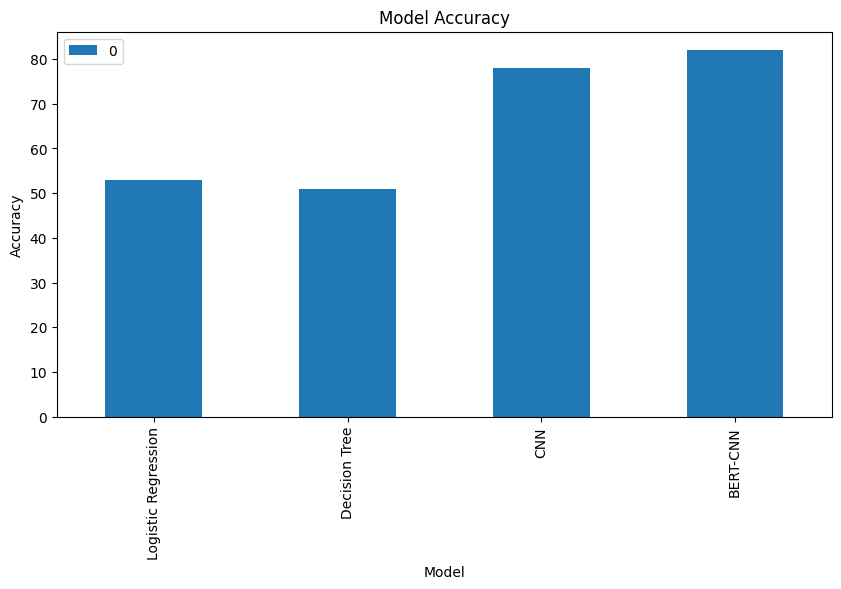

In [ ]:
plot_acc_data.plot(kind="bar",figsize=(10, 5))
plt.title("Model Accuracy")
plt.xlabel("Model")
plt.ylabel("Accuracy")

In [ ]:
plot_opt_acc_data = pd.DataFrame([77,57,57,78],index = ["Adam","SGD","AdaGrad","RMSprop"])

Comparison between optimizers for CNN:

Text(0, 0.5, 'Accuracy')

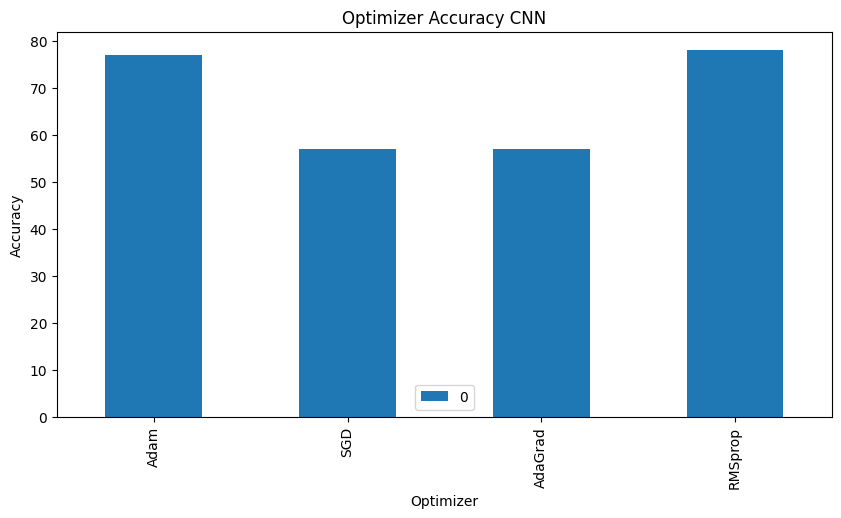

In [ ]:
plot_opt_acc_data.plot(kind="bar",figsize=(10, 5))
plt.title("Optimizer Accuracy CNN")
plt.xlabel("Optimizer")
plt.ylabel("Accuracy")

In [ ]:
lr_model = predict_lr()
y_pred_proba = lr_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)

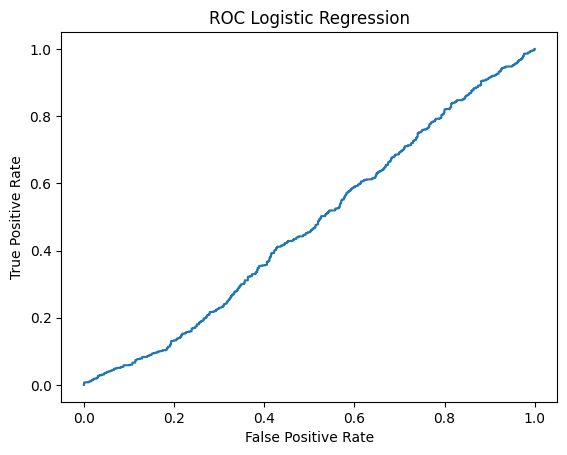

In [ ]:
plt.plot(fpr,tpr)
plt.title("ROC Logistic Regression")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
dt_model = decision_tree()
y_pred_proba = dt_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)

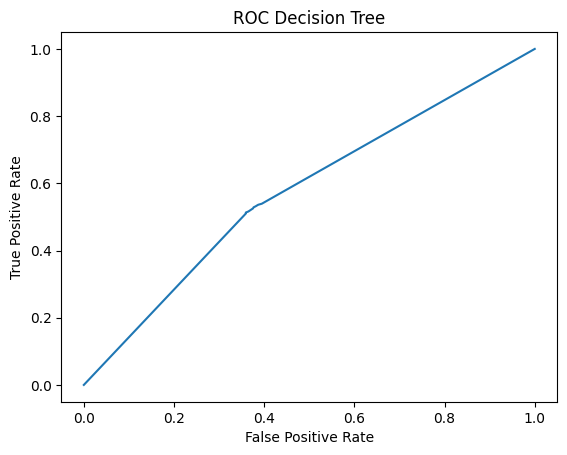

In [ ]:
plt.plot(fpr,tpr)
plt.title("ROC Decision Tree")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
y_pred_preds = bert_cnn_model.predict(X_test_bert.detach().numpy())
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_preds)

48/48 [==============================] - 0s 5ms/step


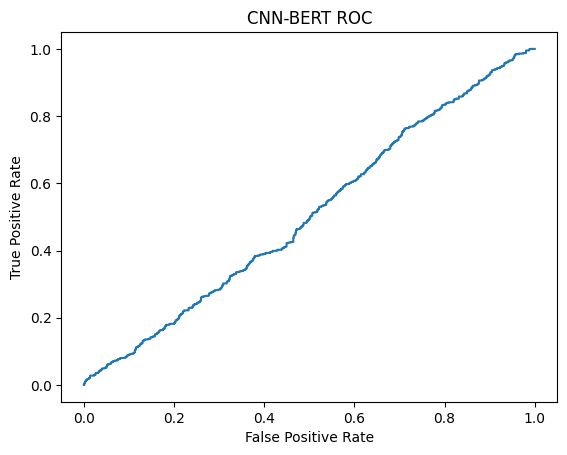

In [ ]:
plt.plot(fpr,tpr)
plt.title("CNN-BERT ROC")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Inference:

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def clean_text(text):
  text = re.sub(r'<[^>]*>', '', text)          # Removing HTML tags
  text = html.unescape(text)                   # Removing HTML escape characters
  text = text.lower().replace('\n',' ').replace('\r','').strip()
  text = re.sub(r'[^\w\s]', '', text)          # Removing non-alphanumeric characters
  text = re.sub(r'\s+', ' ', text).strip()     # Removing spaces
  stop_words = set(stopwords.words('english'))

  lemmatizer = WordNetLemmatizer()
  text = lemmatizer.lemmatize(text)
  word_tokens = word_tokenize(text)

  filtered_sentence = [lemmatizer.lemmatize(w) for w in word_tokens if w not in stop_words]
  text = " ".join(filtered_sentence)

  return text

In [ ]:
# def get_preds(y_probs,threshold):
#   y_pred_test = np.empty_like(y_probs)
#   y_pred_test[:] = (y_probs[:] > threshold) * 1
#   return y_pred_test

In [ ]:
model_cnn = pickle.load(open('/content/drive/MyDrive/bert_cnn_tweets.pkl','rb'))

In [ ]:
def get_inference_bert(tweet,pretrained_bert,model):
  cleaned_tweet = clean_text(tweet)
  tweet_tokens = tokenizer([cleaned_tweet], padding=True, truncation=True)
  ids = torch.tensor(tweet_tokens['input_ids'])
  tweet_embedding = pretrained_bert.bert.embeddings.word_embeddings(ids)
  tweet_embedding_fin = torch.zeros(1, 52, 768)
  tweet_embedding_fin[:, :11, :] = tweet_embedding
  print(tweet_embedding_fin.shape)
  y_pred = model.predict(tweet_embedding_fin.detach().numpy())
  classes_x = np.argmax(y_pred,axis=1)
  if classes_x == 1:
    print("Disaster")
  else:
    print("Not a disaster")

In [ ]:
df_train.shape

In [ ]:
tweet1 = df_train["text"][1]

In [ ]:
get_inference_bert(tweet1,model,model_cnn)